In [0]:
import keras
keras.__version__

Using TensorFlow backend.


'2.0.8'

# 敵対的生成ネットワーク



## 実装の概要

ここで説明するのはdcgan。
生成者ネットワークでの画像のアップサンプリングにConv2DTranspose層を使用する。



## トリック


略

# アーキテクチャ

１、ランダムノイズをジェネレータに入れて出力を得る。    
２、ディスクリメータの訓練。出力された画像と本当の画像をチャンネル方向に重ねて、ラベル１、１をセットにしてディスクリメータに入れて訓練。    
３、ジェネレータ側の訓練。ディスクリメータ側を凍結して、ジェネレータにランダムを入れて正解ラベル１で訓練。

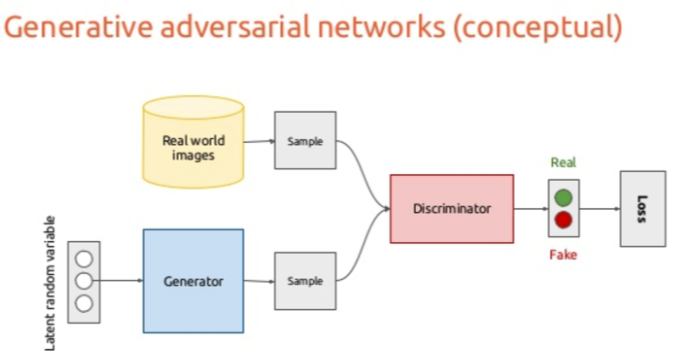

## 生成者ネットワーク（generator）

generatorモデルを定義。ドロップアウトを入れて、ノイズのように見える画像を生成することを抑制する。


In [11]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

## 判別者ネットワーク（discriminator）


discriminatorモデルの定義。生成された画像クラスと、訓練データセットから抽出された本物の画像クラスのどちらかに分類する。


In [12]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# ドロップアウト層を1つ追加。重要なトリック。
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# オプティマイザで勾配刈り込みを使用し（clipvalue）、訓練を安定させるために学習率減衰を使用。（decay）
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

## The adversarial network

Finally, we setup the GAN, which chains the generator and the discriminator. This is the model that, when trained, will move the generator 
in a direction that improves its ability to fool the discriminator. This model turns latent space points into a classification decision, 
"fake" or "real", and it is meant to be trained with labels that are always "these are real images". So training `gan` will updates the 
weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we 
set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the 
discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is 
not what we want!

In [0]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## DCGANの訓練方法

エポックごとに次の処理を実行する。

１、潜在空間から点をランダムに抽出する（ランダムノイズ）    
２、このランダムノイズを使ってジェネレータで画像を生成    
３、生成された画像を本物の画像に混ぜる    
４、本物画像と生成された偽物画像を元にディスクリメータで訓練する    
５、潜在空間から新しい点をランダムに抽出する    
６、ランダムベクトルと目的値を使ってジェネレータを訓練。目的地はどれもディスクリメータが「本物の画像」と予測するようにジェネレータの重みが更新される。ディスクリメータはジェネレータの内部で凍結されるため、更新されるのはジェネレータの重みだけ。このようにジェネレータはディスクリメータを騙すように訓練させる。


In [0]:
!mkdir gan_images

In [14]:
import os
from keras.preprocessing import image

(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
# カエルの画像を選択
x_train = x_train[y_train.flatten() == 6]
#正規化
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './gan_images/'

start = 0
for step in range(iterations):
    #潜在空間(latent space)から点をランダムに抽出
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    # 偽物の画像にデコーディング
    generated_images = generator.predict(random_latent_vectors)

    # 本物画像と生成された画像をチャンネル方向に繋げる！！！
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # 本物画像と偽物画像を区別するラベルを組み立てる
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # ラベルにランダムノイズを追加！重要なトリック
    labels += 0.05 * np.random.random(labels.shape)
    # 【訓練】ディスクリメータを訓練
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # ランダムベクトル
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    # 全て本物画像であることを示すラベルを組み立てる
    misleading_targets = np.zeros((batch_size, 1))

    # 【訓練】dcganモデルでジェネレータを訓練。ディスクリメータは凍結する。
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('gan.h5')

        # Print metrics
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))

        # Save one generated image
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

        # Save one real image, for comparison
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.6791006
adversarial loss at step 0: 0.64733344
discriminator loss at step 100: 0.007070154
adversarial loss at step 100: 12.193487
discriminator loss at step 200: -0.05411806
adversarial loss at step 200: 15.785609
discriminator loss at step 300: 0.04730519
adversarial loss at step 300: 5.1415043
discriminator loss at step 400: -0.092002116
adversarial loss at step 400: 15.827255
discriminator loss at step 500: -0.13778886
adversarial loss at step 500: 15.852797
discriminator loss at step 600: -0.085620634
adversarial loss at step 600: 15.942385
discriminator loss at step 700: -0.15016535
adversarial loss at step 700: 15.942385
discriminator loss at step 800: -0.105197385
adversarial loss at step 800: 15.634961
discriminator loss at step 900: -0.11641254
adversarial loss at step 900: 15.942385
discriminator loss at step 1000: -0.16526926
adversarial loss at step 1000: 15.942385
discriminator loss at step 1100: -0.116866946
adversarial loss at step 1100: 

KeyboardInterrupt: ignored

Let's display a few of our fake images:

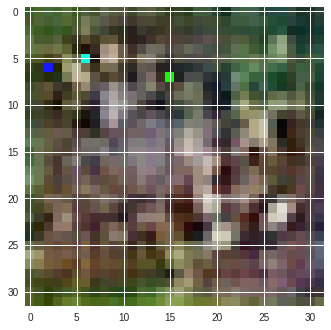

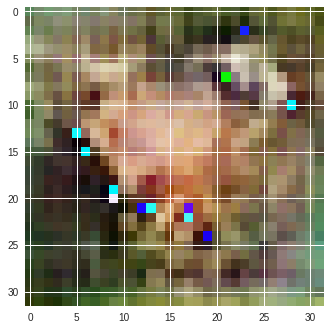

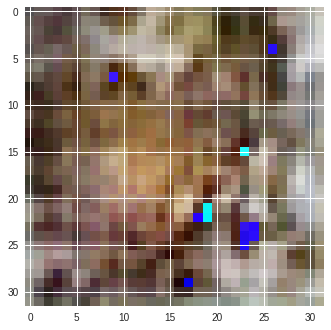

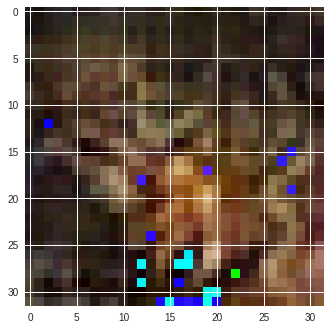

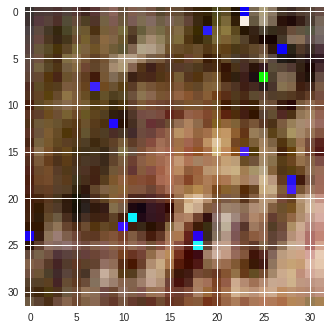

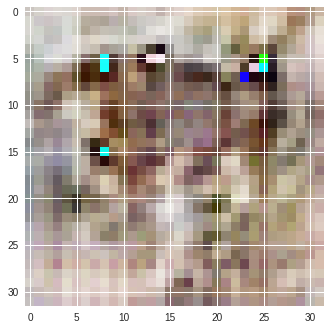

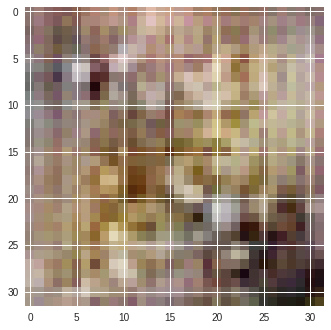

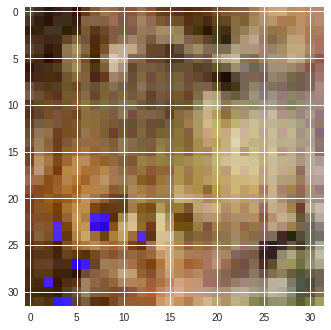

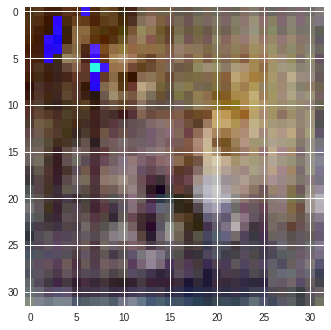

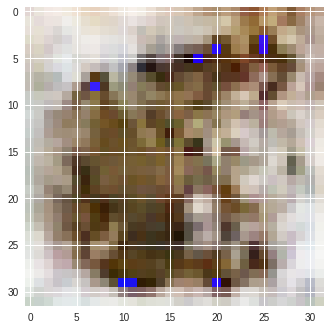

In [16]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

訓練の際には、ジェネレータ（敵対者）の損失値がかなり大きくなる一方、ディスクリメータ（判別者）の損失値が０に近づいていき、ジェネレータを圧倒するようになることがある。
その場合はディスクリメータの学習率を小さくし、ディスクリメータのドロップアウト率を高くする。


# チューニングしてみる

adamのlr0.0004 beta1 0.5、重みを正規分布の標準偏差0.2、leakyRelu0.2を使用。    

https://julianzaidi.wordpress.com/2017/04/24/deep-convolution-gan-dcgan-architecture-and-training/

In [24]:
import keras
from keras import layers
from keras.initializers import RandomNormal
import numpy as np

#==============generator==============
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding='same', kernel_initializer=RandomNormal(stddev=0.02)
                  , bias_initializer=RandomNormal(stddev=0.02))(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same', kernel_initializer=RandomNormal(stddev=0.02)
                  , bias_initializer=RandomNormal(stddev=0.02))(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, 5, padding='same', kernel_initializer=RandomNormal(stddev=0.02)
                 , bias_initializer=RandomNormal(stddev=0.02))(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, 5, padding='same', kernel_initializer=RandomNormal(stddev=0.02)
                 , bias_initializer=RandomNormal(stddev=0.02))(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same', kernel_initializer=RandomNormal(stddev=0.02)
                 , bias_initializer=RandomNormal(stddev=0.02))(x)
x = layers.BatchNormalization()(x)
generator = keras.models.Model(generator_input, x)

#==============discriminator==============
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3, kernel_initializer=RandomNormal(stddev=0.02)
                 , bias_initializer=RandomNormal(stddev=0.02))(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2, kernel_initializer=RandomNormal(stddev=0.02)
                 , bias_initializer=RandomNormal(stddev=0.02))(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2, kernel_initializer=RandomNormal(stddev=0.02)
                 , bias_initializer=RandomNormal(stddev=0.02))(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2, kernel_initializer=RandomNormal(stddev=0.02)
                 , bias_initializer=RandomNormal(stddev=0.02))(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator_optimizer = keras.optimizers.Adam(lr=0.0004, beta_1=0.5, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

#==============define==============
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.Adam(lr=0.0004, beta_1=0.5, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
#==============train==============

import os
from keras.preprocessing import image
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0
    if step % 100 == 0:
#         gan.save_weights('gan.h5')
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.6878047
adversarial loss at step 0: 0.7097721
discriminator loss at step 100: -0.08535769
adversarial loss at step 100: 15.942385
discriminator loss at step 200: -0.13315144
adversarial loss at step 200: 15.942385
discriminator loss at step 300: -0.16991061
adversarial loss at step 300: 15.942385


KeyboardInterrupt: ignored

一様分布に戻す。

In [25]:
import keras
from keras import layers
from keras.initializers import RandomNormal
import numpy as np

#==============generator==============
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
x = layers.BatchNormalization()(x)
generator = keras.models.Model(generator_input, x)

#==============discriminator==============
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator_optimizer = keras.optimizers.Adam(lr=0.0004, beta_1=0.5, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

#==============define==============
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.Adam(lr=0.0004, beta_1=0.5, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
#==============train==============

import os
from keras.preprocessing import image
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0
    if step % 100 == 0:
#         gan.save_weights('gan.h5')
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.6932043
adversarial loss at step 0: 0.6001081
discriminator loss at step 100: 0.60191804
adversarial loss at step 100: 0.121429846
discriminator loss at step 200: -0.10118584
adversarial loss at step 200: 13.54949
discriminator loss at step 300: -0.11288836
adversarial loss at step 300: 15.942385
discriminator loss at step 400: -0.124194145
adversarial loss at step 400: 15.942385
discriminator loss at step 500: -0.13147065
adversarial loss at step 500: 15.942385
discriminator loss at step 600: -0.13799065
adversarial loss at step 600: 15.942385
discriminator loss at step 700: -0.120703325
adversarial loss at step 700: 15.942385


KeyboardInterrupt: ignored

RMPROPに戻す。唯一の違いはbatchnorm。

In [26]:
import keras
from keras import layers
from keras.initializers import RandomNormal
import numpy as np

#==============generator==============
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
x = layers.BatchNormalization()(x)
generator = keras.models.Model(generator_input, x)

#==============discriminator==============
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

#==============define==============
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
#==============train==============

import os
from keras.preprocessing import image
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0
    if step % 100 == 0:
#         gan.save_weights('gan.h5')
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.7011231
adversarial loss at step 0: 0.2600397
discriminator loss at step 100: -0.005909425
adversarial loss at step 100: 15.942385
discriminator loss at step 200: -0.10981369
adversarial loss at step 200: 0.08588703
discriminator loss at step 300: -0.10273268
adversarial loss at step 300: 0.26211596
discriminator loss at step 400: -0.14525214
adversarial loss at step 400: 0.10636975
discriminator loss at step 500: -0.1173933
adversarial loss at step 500: 0.03784273
discriminator loss at step 600: -0.14271675
adversarial loss at step 600: 0.2651483
discriminator loss at step 700: -0.09775008
adversarial loss at step 700: 7.375839
discriminator loss at step 800: -0.09849675
adversarial loss at step 800: 0.017633727
discriminator loss at step 900: -0.101872586
adversarial loss at step 900: 0.03180297
discriminator loss at step 1000: -0.13743111
adversarial loss at step 1000: 0.032331593
discriminator loss at step 1100: -0.16813865
adversarial loss at step 1

KeyboardInterrupt: ignored

バッチ正規化も消す。LeakyReLUだけ変更された状態。

In [27]:
import keras
from keras import layers
from keras.initializers import RandomNormal
import numpy as np

#==============generator==============
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Reshape((16, 16, 128))(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)

#==============discriminator==============
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU(alpha=0.2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.6)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

#==============define==============
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')
#==============train==============

import os
from keras.preprocessing import image
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()
x_train = x_train[y_train.flatten() == 6]
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = './gan_images/'
start = 0
for step in range(iterations):
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    generated_images = generator.predict(random_latent_vectors)
    stop = start + batch_size
    real_images = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    labels += 0.05 * np.random.random(labels.shape)
    d_loss = discriminator.train_on_batch(combined_images, labels)
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))
    misleading_targets = np.zeros((batch_size, 1))
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
      start = 0
    if step % 100 == 0:
#         gan.save_weights('gan.h5')
        print('discriminator loss at step %s: %s' % (step, d_loss))
        print('adversarial loss at step %s: %s' % (step, a_loss))
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))
        img = image.array_to_img(real_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 0: 0.68464077
adversarial loss at step 0: 0.6985964
discriminator loss at step 100: -0.16067925
adversarial loss at step 100: 15.942385
discriminator loss at step 200: -0.1596111
adversarial loss at step 200: 15.942385
discriminator loss at step 300: 0.46759024
adversarial loss at step 300: 1.3138639
discriminator loss at step 400: 0.6082485
adversarial loss at step 400: 1.5603939
discriminator loss at step 500: 0.6769352
adversarial loss at step 500: 0.7502997
discriminator loss at step 600: 0.68728524
adversarial loss at step 600: 0.78481275
discriminator loss at step 700: 0.6943842
adversarial loss at step 700: 0.7682839
discriminator loss at step 800: 0.7012085
adversarial loss at step 800: 0.7468711
discriminator loss at step 900: 0.70556366
adversarial loss at step 900: 0.8417637
discriminator loss at step 1000: 0.70786774
adversarial loss at step 1000: 0.7302321
discriminator loss at step 1100: 0.7075435
adversarial loss at step 1100: 0.74727213
discri

discriminator loss at step 4800: 0.69387376
adversarial loss at step 4800: 0.76598877
discriminator loss at step 4900: 0.67796624
adversarial loss at step 4900: 0.8122104
discriminator loss at step 5000: 0.6805752
adversarial loss at step 5000: 0.7552663
discriminator loss at step 5100: 0.6566775
adversarial loss at step 5100: 1.0075505
discriminator loss at step 5200: 0.7503804
adversarial loss at step 5200: 0.7398937
discriminator loss at step 5300: 0.6855293
adversarial loss at step 5300: 0.81590116
discriminator loss at step 5400: 0.71145856
adversarial loss at step 5400: 0.7742573
discriminator loss at step 5500: 0.6776298
adversarial loss at step 5500: 0.78467923
discriminator loss at step 5600: 0.680981
adversarial loss at step 5600: 0.78992033
discriminator loss at step 5700: 0.7075316
adversarial loss at step 5700: 0.86770314
discriminator loss at step 5800: 0.6716836
adversarial loss at step 5800: 0.7708486
discriminator loss at step 5900: 0.67443925
adversarial loss at step 

discriminator loss at step 9600: 0.6201645
adversarial loss at step 9600: 0.89530456
discriminator loss at step 9700: 0.8916885
adversarial loss at step 9700: 1.301126
discriminator loss at step 9800: 0.74835294
adversarial loss at step 9800: 0.7772895
discriminator loss at step 9900: 0.69701207
adversarial loss at step 9900: 0.8357557


Froggy with some pixellated artifacts.

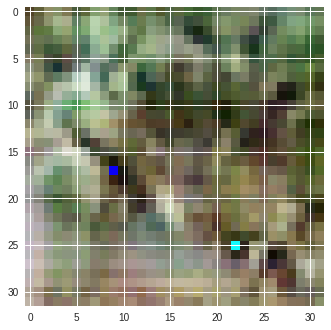

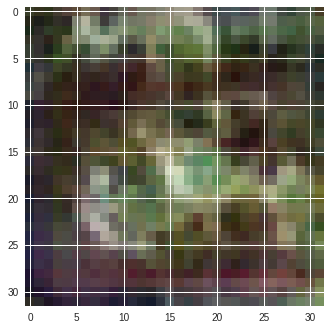

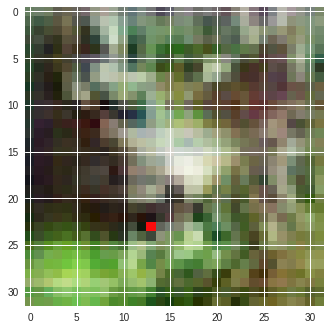

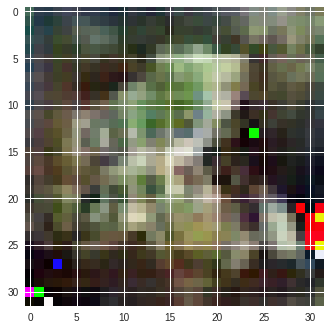

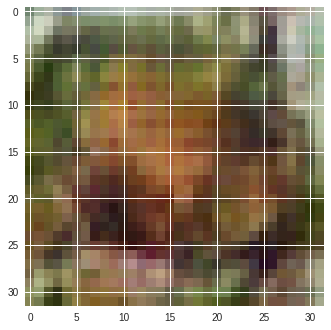

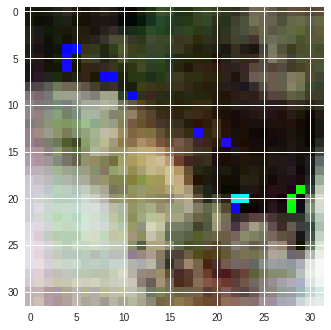

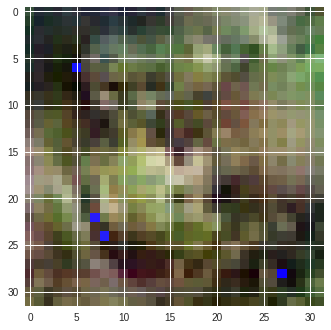

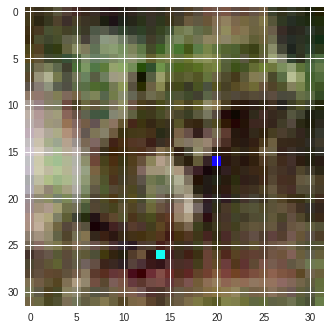

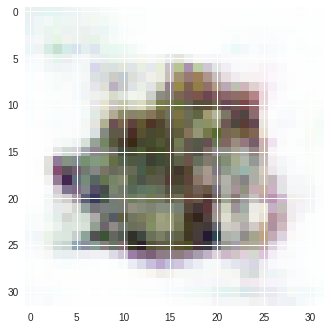

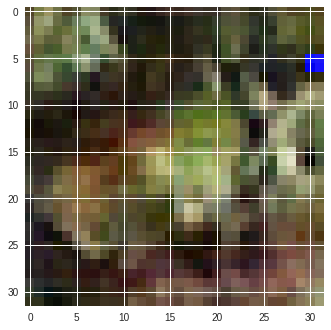

In [28]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()